#Set up & Install

In [ ]:
!pip install torchmetrics

#Model

Comparing model
- Original LSTM
- Bidirectional LSTM
- Unidirectional GRU
- Custom Mamba
- MG SMM
- MG SMM-s

##Original LSTM

In [ ]:
import torch
import torch.nn as nn

class OriginalLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(OriginalLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # print(x.shape)
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

##Bi LSTM

In [ ]:
import torch.nn as nn

class BidirectionalLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BidirectionalLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # batch_first=True allows input and output tensors of shape (batch_size, seq_len, features)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        # The output of a bidirectional LSTM is the concatenation of the forward and backward hidden states
        # So the linear layer's input size is 2 * hidden_size
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        # Initialize hidden and cell states
        # For bidirectional LSTM, the shape is (2 * num_layers, batch_size, hidden_size)
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, 2 * hidden_size)

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

##Original GRU

In [ ]:
import torch
import torch.nn as nn

class UnidirectionalGRUModel(nn.Module):
    """
    A standard (unidirectional) Gated Recurrent Unit (GRU) model in PyTorch.
    It processes a sequence and uses the last hidden state for a linear classification/regression layer.
    """
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        """
        Initializes the UnidirectionalGRUModel.

        Args:
            input_size (int): The number of expected features in the input $x$.
            hidden_size (int): The number of features in the hidden state $h$.
            num_layers (int): Number of recurrent layers.
            output_size (int): The size of the output from the final linear layer.
        """
        super(UnidirectionalGRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Changed 'bidirectional=True' to 'bidirectional=False' (or just omit it, as False is the default)
        # batch_first=True allows input and output tensors of shape (batch_size, seq_len, features)
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=False)

        # The output of a unidirectional GRU at each time step is just the hidden_size
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        Performs the forward pass of the model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_len, input_size).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, output_size).
        """
        # Initialize the hidden state
        # For a unidirectional GRU, the shape is (num_layers, batch_size, hidden_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate GRU
        # out: tensor of shape (batch_size, seq_length, hidden_size)
        # hn: tensor of shape (num_layers, batch_size, hidden_size)
        out, _ = self.gru(x, h0)

        # Decode the hidden state of the *last* time step.
        # out[:, -1, :] selects the output features for the last element in the sequence
        # for all batches. This output is the final hidden state of the top layer.
        out = self.fc(out[:, -1, :])
        return out

##Custom mamba

In [ ]:
class Custom_MambaCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Custom_MambaCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # cell input gate
        self.W_ic = nn.Linear(input_size, hidden_size)
        self.W_hc = nn.Linear(hidden_size, hidden_size)
        self.b_c = nn.Parameter(torch.zeros(hidden_size))

    def forward(self, x, hidden_state):
        h_prev = hidden_state

        # Hidden state
        h_t = self.W_ic(x) + self.W_hc(h_prev) + self.b_c

        return h_t

class Custom_MambaModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(Custom_MambaModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm_cells = nn.ModuleList([Custom_MambaCell(input_size if i == 0 else hidden_size, hidden_size) for i in range(num_layers)])
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        hidden_state = [torch.zeros(batch_size, self.hidden_size).to(x.device) # Initialize with a single tensor
                         for _ in range(self.num_layers)]

        for t in range(seq_len):
            input_t = x[:, t, :]
            for i in range(self.num_layers):
                h_prev = hidden_state[i]

                # Mamba part (using the Custom_MambaCell)
                h_t = self.lstm_cells[i](input_t, h_prev) # Pass a single tensor
                hidden_state[i] = h_t
                input_t = h_t # Use the output of the current layer as input for the next layer

        # Decode the hidden state of the last time step of the last layer
        last_hidden_state = hidden_state[-1]
        out = self.fc(last_hidden_state)
        return out

##MG SMM

In [ ]:
class MgSmmCell(nn.Module):
    def __init__(self, input_size, hidden_size, gate_size):
        super(MgSmmCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gate_size = gate_size

        # linear input gate
        self.W_ic = nn.Linear(input_size, hidden_size)
        self.W_hc = nn.Linear(hidden_size, hidden_size)
        self.b_c = nn.Parameter(torch.zeros(hidden_size))

        # multiplicative input gate
        self.W_in = nn.Linear(gate_size, gate_size)

    def forward(self, x, hidden_state):
        h_prev, g_prev = hidden_state

        # Hidden state
        h_t =  self.W_ic(x) + self.W_hc(h_prev) + self.b_c
        intermediate_x = torch.repeat_interleave(x, self.gate_size, dim=1)
        g_t =  self.W_in(g_prev) * intermediate_x

        return h_t, g_t

class MgSmmModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, gate_size = 0):
        """
        Initializes the CustomMambaModel.

        Args:
            input_size (int): The number of expected features in the input $x$.
            hidden_size (int): The number of features in the hidden state $h$.
            num_layers (int): Number of recurrent layers.
            output_size (int): The size of the output from the final linear layer.
            gate_size (int): The number of features in the multiplicative gate cell.
        """
        super(MgSmmModel, self).__init__()
        self.hidden_size = hidden_size
        if gate_size == 0:
            gate_size = int(hidden_size/2)
        self.gate_size = gate_size

        self.num_layers = num_layers
        self.lstm_cells = nn.ModuleList([MgSmmCell(input_size if i == 0 else hidden_size, hidden_size, gate_size) for i in range(num_layers)])

        self.W_h = nn.Linear(hidden_size, output_size)
        self.W_g = nn.Linear(gate_size, output_size)

    def forward(self, x):
        """
        Performs the forward pass of the model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_len, input_size).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, output_size).
        """
        batch_size, seq_len, _ = x.size()
        hidden_state = [(torch.zeros(batch_size, self.hidden_size).to(x.device),
                                torch.ones(batch_size, self.gate_size).to(x.device)
                         ) for _ in range(self.num_layers)]

        for t in range(seq_len):
            input_t = x[:, t, :]
            for i in range(self.num_layers):
                h_prev, c_prev = hidden_state[i]

                # Mamba part (using the Custom_MambaCell)
                h_t, c_t = self.lstm_cells[i](input_t, (h_prev, c_prev)) # Pass a single tensor
                hidden_state[i] = (h_t, c_prev)
                input_t = h_t # Use the output of the current layer as input for the next layer

        # Decode the hidden state of the last time step of the last layer
        h_prev, g_prev = hidden_state[-1]

        out = self.W_h(h_prev) + self.W_g(g_prev)
        return out

##MG SMM-s

In [ ]:
import torch
import torch.nn as nn
import numpy as np

class MgSmmSCell(nn.Module):
    def __init__(self, input_size, hidden_size, gate_size):
        super(MgSmmSCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gate_size = gate_size

        # linear input gate
        self.W_ic = nn.Linear(input_size, hidden_size)
        self.W_hc = nn.Linear(hidden_size, hidden_size)
        self.b_c = nn.Parameter(torch.zeros(hidden_size))

        # multiplicative input gate
        self.W_in = nn.Linear(gate_size, gate_size)

    def forward(self, x, hidden_state):
        h_prev, g_prev = hidden_state

        # Hidden state
        h_t =  self.W_ic(x) + self.W_hc(h_prev) + self.b_c
        g_t =  self.W_in(g_prev) * np.repeat(x, self.gate_size, axis=1)

        return h_t, g_t

class MgSmmSModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, gate_size = 0):
        """
        Initializes the CustomMambaModel.

        Args:
            input_size (int): The number of expected features in the input $x$.
            hidden_size (int): The number of features in the hidden state $h$.
            num_layers (int): Number of recurrent layers.
            output_size (int): The size of the output from the final linear layer.
            gate_size (int): The number of features in the multiplicative gate cell.
        """
        super(MgSmmSModel, self).__init__()
        self.hidden_size = hidden_size
        if gate_size == 0:
            gate_size = int(hidden_size/2)
        self.gate_size = gate_size

        self.num_layers = num_layers
        self.lstm_cells = nn.ModuleList([MgSmmSCell(input_size if i == 0 else hidden_size, hidden_size, gate_size) for i in range(num_layers)])

        self.W_h = nn.Linear(hidden_size, hidden_size)
        self.W_g = nn.Linear(gate_size, hidden_size)
        self.W_x = nn.Linear(input_size, hidden_size)

        self.W_1d = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        Performs the forward pass of the model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_len, input_size).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, output_size).
        """
        batch_size, seq_len, _ = x.size()
        hidden_state = [(torch.zeros(batch_size, self.hidden_size).to(x.device),
                                torch.ones(batch_size, self.gate_size).to(x.device)
                         ) for _ in range(self.num_layers)]

        for t in range(seq_len):
            input_t = x[:, t, :]
            for i in range(self.num_layers):
                h_prev, g_prev = hidden_state[i]

                # Mamba part (using the Custom_MambaCell)
                h_t, c_t = self.lstm_cells[i](input_t, (h_prev, g_prev)) # Pass a single tensor
                hidden_state[i] = (h_t, g_prev)
                input_t = h_t # Use the output of the current layer as input for the next layer

        # Decode the hidden state of the last time step of the last layer
        h_prev, g_prev = hidden_state[-1]

        out = self.W_h(h_prev) + self.W_g(g_prev) + self.W_x(x[:, seq_len - 1, :])
        out = self.W_1d(out)
        return out

#Covid Dataset
from https://github.com/GoogleCloudPlatform/covid-19-open-data/blob/main/docs/table-epidemiology.md

In [ ]:
!gdown 17OT5EC49yCgBdbG-SPbobIBqBN17BV1v

Downloading...
From (original): https://drive.google.com/uc?id=17OT5EC49yCgBdbG-SPbobIBqBN17BV1v
From (redirected): https://drive.google.com/uc?id=17OT5EC49yCgBdbG-SPbobIBqBN17BV1v&confirm=t&uuid=3182c95e-84d1-480e-82e9-25b71a97e5b6
To: /content/epidemiology.csv
100% 521M/521M [00:04<00:00, 112MB/s]


In [ ]:
# mapping code from https://datahub.io/core/country-list
!gdown 1_a7Vev2gkCXzn54gN7GD63MUBUb5ZeAD

Downloading...
From: https://drive.google.com/uc?id=1_a7Vev2gkCXzn54gN7GD63MUBUb5ZeAD
To: /content/alpha2_country.csv
100% 3.87k/3.87k [00:00<00:00, 7.21MB/s]


In [ ]:
import pandas as pd
import torch

try:
    df = pd.read_csv('/content/epidemiology.csv')
except FileNotFoundError:
    print("Error: thailand_covid_data.csv not found. Please make sure the file is in the correct directory.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
country_code_df = pd.read_csv('/content/alpha2_country.csv')
country_code_df

,Name,Code
0,Afghanistan,AF
1,Albania,AL
2,Algeria,DZ
3,American Samoa,AS
4,Andorra,AD
...,...,...
244,Western Sahara,EH
245,Yemen,YE
246,Zambia,ZM
247,Zimbabwe,ZW


In [ ]:
selected_contry_codes = ['US', 'IN', 'BR', 'FR', 'DE',
                                      'GB', 'RU', 'IT', 'TR', 'ES',
                                      'VN', 'AR', 'AU', 'AT', 'BD',
                                      'BE', 'BG', 'CA', 'CL', 'CN',
                                      'CU', 'DK', 'FI', 'GE', 'GR',
                                      'ID', 'JP', 'JO', 'KE', 'KR',
                                      'LR', 'MY','ML', 'MX', 'NL',
                                      'NO', 'PH','SE', 'CH', 'TH']
selected_country_names = ['USA'   , 'INDIA', 'BRAZIL', 'FRANCE', 'GERMANY',
                                        'UK', 'RUSSIA', 'ITALY', 'TURKEY', 'SPAIN',
                                        'VIETNAM', 'ARGENTINA', 'AUSTRALIA', 'AUSTRIA', 'BANGLADESH',
                                        'BELGIUM', 'BULGARIA', 'CANADA', 'CHILE', 'CHINA',
                                        'CUBA', 'DENMARK', 'FINLAND', 'GEORGIA', 'GREECE',
                                        'INDONESIA', 'JAPAN', 'JORDAN'  , 'KENYA', 'KOREA',
                                        'LIBERIA', 'MALAYSIA', 'MALI', 'MEXICO', 'NETHERLANDS',
                                        'NORWAY', 'PHILIPPINES', 'SWEDEN', 'SWITZERLAND', 'THAILAND']

df['date'] = pd.to_datetime(df['date'])

start_date = '2020-01-06'
end_date = '2022-06-06'

df = df[(df['date'] >= start_date) & (df['date'] <= end_date)].copy()

clean_df = df.drop(['new_confirmed', 'new_deceased', 'new_recovered', 'new_tested', "cumulative_deceased", "cumulative_recovered", "cumulative_tested"], axis = 1)

country_dfs = []

for code in selected_contry_codes:
    country_df = clean_df[clean_df['location_key'] == code].copy()
    country_dfs.append(country_df)

print(f"List of DataFrames created for the {len(selected_contry_codes)} countries.")

List of DataFrames created for the 40 countries.


#Dataset prep format

In [ ]:
def create_sequences(data, seq_length, pred_idx):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length, pred_idx] # Predict only the first column ('cumulative_confirmed')
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch

## Covid part
dataset_name = "Covid"

data_list = []

for i in range(len(selected_contry_codes)):

    # Select the columns for the time series
    cumulative_confirmed_data = country_dfs[i]['cumulative_confirmed'].values.astype(float)

    # Scale the 'cumulative_confirmed' data
    scaler_confirmed = MinMaxScaler(feature_range=(-1, 1))
    cumulative_confirmed_scaled = scaler_confirmed.fit_transform(cumulative_confirmed_data.reshape(-1, 1))

    ####### dataset part #####
    seq_length = 30 # You can adjust this

    X, y = create_sequences(cumulative_confirmed_scaled, seq_length,0) # perdict temp 0

    # Convert to PyTorch tensors
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)

    # Reshape y to have a size of (batch_size, 1)
    y = y.unsqueeze(1)

    # Split into training and testing sets
    train_size = int(len(X) * 0.8)
    test_size = len(X) - train_size

    X_raw_train, X_raw_test = X[:train_size], X[train_size:]
    y_raw_train, y_raw_test = y[:train_size], y[train_size:]

    data_list.append((X_raw_train, y_raw_train, X_raw_test, y_raw_test))

#Training

Hyperparameter and dataset

In [ ]:
import torch
import numpy as np

# Set a fixed seed for reproducibility
seed = 1234
torch.manual_seed(seed)
np.random.seed(seed)

In [ ]:
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Define hyperparameters
input_size = X_raw_train.shape[-1] # Updated input size to include 'cumulative_confirmed'
hidden_size = 32
num_layers = 1
output_size = 1
num_epochs = 1000 # You can adjust this
learning_rate = 0.001

num_runs = 1

# Create DataLoader for training and testing
train_raw_dataset = TensorDataset(X_raw_train, y_raw_train)
test_raw_dataset = TensorDataset(X_raw_test, y_raw_test)

batch_size = 64 # You can adjust this
train_raw_loader = DataLoader(train_raw_dataset, batch_size=batch_size, shuffle=False)
test_raw_loader = DataLoader(test_raw_dataset, batch_size=batch_size, shuffle=False)

# Experiment


##Bi-LSTM

In [ ]:
def bi_lstm_part(train_data, eval_loader, test_data, num_runs):  #train_raw_loader, test_raw_loader
  # Initialize a list to store test losses
  bi_lstm_test_losses = []

  for run in range(num_runs):
      print(f"\n--- bi LSTM Run {run + 1}/{num_runs} ---")

      # Initialize the model
      model = BidirectionalLSTMModel(input_size, hidden_size, num_layers, output_size).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

      # Define loss function and optimizer
      criterion = nn.L1Loss()
      optimizer = optim.Adam(model.parameters(), lr=learning_rate)

      # Early stopping parameters
      best_eval_loss = float('inf')
      patience = 50  # Number of epochs to wait for improvement
      epochs_no_improve = 0

      # Training loop
      # print("Starting training...")
      for epoch in range(num_epochs):
          model.train()
          for i, (sequences, targets) in enumerate(train_data):
              # Move data to GPU if available
              sequences = sequences.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
              targets = targets.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

              # Forward pass
              outputs = model(sequences)
              loss = criterion(outputs, targets)

              # Backward and optimize
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()

          # Print loss every few epochs
          # if (epoch + 1) % 50 == 0:
          #     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

          # Evaluation on the evaluation set
          model.eval()
          with torch.no_grad():
              eval_loss = 0
              for sequences, targets in eval_loader:
                # Move data to GPU if available
                  sequences = sequences.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
                  targets = targets.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

                  outputs = model(sequences)
                  eval_loss += criterion(outputs, targets).item()

              avg_eval_loss = eval_loss / len(eval_loader)

          # Early stopping check
          if avg_eval_loss < best_eval_loss:
              best_eval_loss = avg_eval_loss
              epochs_no_improve = 0
              # Optionally save the best model state
              # torch.save(model.state_dict(), 'best_model.pth')
          else:
              epochs_no_improve += 1
              if epochs_no_improve == patience:
                  # print(f'Early stopping at epoch {epoch+1}')
                  break # Stop training loop

      # print("Training finished.")

      # Evaluation on the test set
      model.eval()
      with torch.no_grad():
          test_loss = 0
          for sequences, targets in test_data:
              # Move data to GPU if available
              sequences = sequences.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
              targets = targets.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

              outputs = model(sequences)
              test_loss += criterion(outputs, targets).item()

          avg_test_loss = test_loss / len(test_data)
          # print(f'Original LSTM Test Loss: {avg_test_loss:.4f}')
          bi_lstm_test_losses.append(avg_test_loss)

  return bi_lstm_test_losses

##Original LSTM

In [ ]:
def OriginalLSTM_part(train_data, eval_loader, test_data, num_runs):  #train_raw_loader, test_raw_loader
  # Initialize a list to store test losses
  original_lstm_test_losses = []

  for run in range(num_runs):
      print(f"\n--- Original LSTM Run {run + 1}/{num_runs} ---")

      # Initialize the model
      model = OriginalLSTMModel(input_size, hidden_size, num_layers, output_size).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

      # Define loss function and optimizer
      criterion = nn.L1Loss()
      optimizer = optim.Adam(model.parameters(), lr=learning_rate)

      # Early stopping parameters
      best_eval_loss = float('inf')
      patience = 50  # Number of epochs to wait for improvement
      epochs_no_improve = 0

      # Training loop
      # print("Starting training...")
      for epoch in range(num_epochs):
          model.train()
          for i, (sequences, targets) in enumerate(train_data):
              # Move data to GPU if available
              sequences = sequences.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
              targets = targets.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

              # Forward pass
              outputs = model(sequences)
              loss = criterion(outputs, targets)

              # Backward and optimize
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()

          # Print loss every few epochs
          # if (epoch + 1) % 50 == 0:
          #     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

          # Evaluation on the evaluation set
          model.eval()
          with torch.no_grad():
              eval_loss = 0
              for sequences, targets in eval_loader:
                  # Move data to GPU if available
                  sequences = sequences.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
                  targets = targets.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

                  outputs = model(sequences)
                  eval_loss += criterion(outputs, targets).item()

              avg_eval_loss = eval_loss / len(eval_loader)

          # Early stopping check
          if avg_eval_loss < best_eval_loss:
              best_eval_loss = avg_eval_loss
              epochs_no_improve = 0
              # Optionally save the best model state
              # torch.save(model.state_dict(), 'best_model.pth')
          else:
              epochs_no_improve += 1
              if epochs_no_improve == patience:
                  # print(f'Early stopping at epoch {epoch+1}')
                  break # Stop training loop

      # print("Training finished.")

      # Evaluation on the test set
      model.eval()
      with torch.no_grad():
          test_loss = 0
          for sequences, targets in test_data:
              # Move data to GPU if available
              sequences = sequences.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
              targets = targets.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

              outputs = model(sequences)
              test_loss += criterion(outputs, targets).item()

          avg_test_loss = test_loss / len(test_data)
          # print(f'Original LSTM Test Loss: {avg_test_loss:.4f}')
          original_lstm_test_losses.append(avg_test_loss)

  return original_lstm_test_losses

##Original GRU

In [ ]:
def OriginalGRU_part(train_data, eval_loader, test_data, num_runs):  #train_raw_loader, test_raw_loader
  # Initialize a list to store test losses
  original_gru_test_losses = []

  for run in range(num_runs):
      print(f"\n--- Original GRU Run {run + 1}/{num_runs} ---")

      # Initialize the model
      model = UnidirectionalGRUModel(input_size, hidden_size, num_layers, output_size).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

      # Define loss function and optimizer
      criterion = nn.L1Loss()
      optimizer = optim.Adam(model.parameters(), lr=learning_rate)

      # Early stopping parameters
      best_eval_loss = float('inf')
      patience = 50  # Number of epochs to wait for improvement
      epochs_no_improve = 0

      # Training loop
      # print("Starting training...")
      for epoch in range(num_epochs):
          model.train()
          for i, (sequences, targets) in enumerate(train_data):
              # Move data to GPU if available
              sequences = sequences.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
              targets = targets.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

              # Forward pass
              outputs = model(sequences)
              loss = criterion(outputs, targets)

              # Backward and optimize
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()

          # Print loss every few epochs
          # if (epoch + 1) % 50 == 0:
          #     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

          # Evaluation on the evaluation set
          model.eval()
          with torch.no_grad():
              eval_loss = 0
              for sequences, targets in eval_loader:
                  # Move data to GPU if available
                  sequences = sequences.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
                  targets = targets.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

                  outputs = model(sequences)
                  eval_loss += criterion(outputs, targets).item()

              avg_eval_loss = eval_loss / len(eval_loader)

          # Early stopping check
          if avg_eval_loss < best_eval_loss:
              best_eval_loss = avg_eval_loss
              epochs_no_improve = 0
              # Optionally save the best model state
              # torch.save(model.state_dict(), 'best_model.pth')
          else:
              epochs_no_improve += 1
              if epochs_no_improve == patience:
                  # print(f'Early stopping at epoch {epoch+1}')
                  break # Stop training loop

      # print("Training finished.")

      # Evaluation on the test set
      model.eval()
      with torch.no_grad():
          test_loss = 0
          for sequences, targets in test_data:
              # Move data to GPU if available
              sequences = sequences.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
              targets = targets.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

              outputs = model(sequences)
              test_loss += criterion(outputs, targets).item()

          avg_test_loss = test_loss / len(test_data)
          # print(f'Original GRU Test Loss: {avg_test_loss:.4f}')
          original_gru_test_losses.append(avg_test_loss)

  return original_gru_test_losses

##Custom Mamba

In [ ]:
def custom_Mamba_part(train_data, eval_loader, test_data, num_runs, loss_function = nn.L1Loss(), eval_function = nn.MSELoss()):  #train_raw_loader, test_raw_loader
  # Initialize a list to store test losses
  custom_Mamba_test_losses = []

  for run in range(num_runs):
      print(f"\n--- Custom Mamba Run {run + 1}/{num_runs} ---")

      # Initialize the model
      model = Custom_MambaModel(input_size, hidden_size, num_layers, output_size).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

      # Define loss function and optimizer
      criterion = loss_function
      optimizer = optim.Adam(model.parameters(), lr=learning_rate)

      # Early stopping parameters
      best_eval_loss = float('inf')
      patience = 50  # Number of epochs to wait for improvement
      epochs_no_improve = 0

      # Training loop
      # print("Starting training...")
      for epoch in range(num_epochs):
          model.train()
          for i, (sequences, targets) in enumerate(train_data):
              # Move data to GPU if available
              sequences = sequences.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
              targets = targets.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

              # Forward pass
              outputs = model(sequences)
              loss = criterion(outputs, targets)

              # Backward and optimize
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()

          # Print loss every few epochs
          # if (epoch + 1) % 50 == 0:
          #     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

          # Evaluation on the evaluation set
          model.eval()
          with torch.no_grad():
              eval_loss = 0
              for sequences, targets in eval_loader:
                  # Move data to GPU if available
                  sequences = sequences.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
                  targets = targets.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

                  outputs = model(sequences)
                  eval_loss += criterion(outputs, targets).item()

              avg_eval_loss = eval_loss / len(eval_loader)

          # Early stopping check
          if avg_eval_loss < best_eval_loss:
              best_eval_loss = avg_eval_loss
              epochs_no_improve = 0
              # Optionally save the best model state
              # torch.save(model.state_dict(), 'best_model.pth')
          else:
              epochs_no_improve += 1
              if epochs_no_improve == patience:
                  # print(f'Early stopping at epoch {epoch+1}')
                  break # Stop training loop

      # print("Training finished.")

      # Evaluation on the test set
      model.eval()
      with torch.no_grad():
          test_loss = 0
          for sequences, targets in test_data:
              # Move data to GPU if available
              sequences = sequences.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
              targets = targets.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

              outputs = model(sequences)
              test_loss += eval_function(outputs, targets).item()

          avg_test_loss = test_loss / len(test_data)
          # print(f'Custom mamba Test Loss: {avg_test_loss:.4f}')
          custom_Mamba_test_losses.append(avg_test_loss)

  return custom_Mamba_test_losses

##MG SMM

In [ ]:
def mg_smm_part(train_data, eval_loader, test_data, num_runs, loss_function = nn.L1Loss(), eval_function = nn.MSELoss(), gate_size = 32):  #train_raw_loader, test_raw_loader
  # Initialize a list to store test losses
  mg_smm_test_losses = []

  for run in range(num_runs):
      # print(f"\n--- mg_smm Mamba Run {run + 1}/{num_runs} ---")

      # Initialize the model
      model = MgSmmModel(input_size, hidden_size, num_layers, output_size, gate_size).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

      # Define loss function and optimizer
      criterion = loss_function
      optimizer = optim.Adam(model.parameters(), lr=learning_rate)

      ## Early stopping parameters
      best_eval_loss = float('inf')
      patience = 50  # Number of epochs to wait for improvement
      epochs_no_improve = 0

      # Training loop
      # print("Starting training...")
      for epoch in range(num_epochs):
          model.train()
          for i, (sequences, targets) in enumerate(train_data):
              # Move data to GPU if available
              sequences = sequences.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
              targets = targets.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

              # Forward pass
              outputs = model(sequences)
              loss = criterion(outputs, targets)

              # Backward and optimize
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()

          # Print loss every few epochs
          # if (epoch + 1) % 50 == 0:
          #     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

          # Evaluation on the evaluation set
          model.eval()
          with torch.no_grad():
              eval_loss = 0
              for sequences, targets in eval_loader:
                # Move data to GPU if available
                  sequences = sequences.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
                  targets = targets.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

                  outputs = model(sequences)
                  eval_loss += criterion(outputs, targets).item()

              avg_eval_loss = eval_loss / len(eval_loader)

          # Early stopping check
          if avg_eval_loss < best_eval_loss:
              best_eval_loss = avg_eval_loss
              epochs_no_improve = 0
              # Optionally save the best model state
              # torch.save(model.state_dict(), 'best_model.pth')
          else:
              epochs_no_improve += 1
              if epochs_no_improve == patience:
                  print(f'Early stopping at epoch {epoch+1}')
                  break # Stop training loop

      # print("Training finished.")

      # Evaluation on the test set
      model.eval()
      with torch.no_grad():
          test_loss = 0
          for sequences, targets in test_data:
              # Move data to GPU if available
              sequences = sequences.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
              targets = targets.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

              outputs = model(sequences)
              test_loss += eval_function(outputs, targets).item()

          avg_test_loss = test_loss / len(test_data)
          print(f'mg_smm mamba Test Loss: {avg_test_loss:.4f}')
          mg_smm_test_losses.append(avg_test_loss)

  return mg_smm_test_losses

##MG SMM-s

In [ ]:
def mg_smm_s_part(train_data, eval_loader, test_data, num_runs, loss_function = nn.L1Loss(), eval_function = nn.MSELoss(), gate_size = 32):  #train_raw_loader, test_raw_loader
  # Initialize a list to store test losses
  mg_smm_s_test_losses = []

  for run in range(num_runs):
      # print(f"\n--- mg_smm_s Mamba Run {run + 1}/{num_runs} ---")

      # Initialize the model
      model = MgSmmSModel(input_size, hidden_size, num_layers, output_size, gate_size)
      # .to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

      # Define loss function and optimizer
      criterion = loss_function
      optimizer = optim.Adam(model.parameters(), lr=learning_rate)

      # Early stopping parameters
      best_eval_loss = float('inf')
      patience = 50  # Number of epochs to wait for improvement
      epochs_no_improve = 0

      # Training loop
      # print("Starting training...")
      for epoch in range(num_epochs):
          model.train()
          for i, (sequences, targets) in enumerate(train_data):
              # Move data to GPU if available
              # sequences = sequences.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
              # targets = targets.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

              # Forward pass
              outputs = model(sequences)
              loss = criterion(outputs, targets)

              # Backward and optimize
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()

          # Print loss every few epochs
          # if (epoch + 1) % 50 == 0:
          #     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

          # Evaluation on the evaluation set
          model.eval()
          with torch.no_grad():
              eval_loss = 0
              for sequences, targets in eval_loader:
                  # Move data to GPU if available
                  # sequences = sequences.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
                  # targets = targets.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

                  outputs = model(sequences)
                  eval_loss += criterion(outputs, targets).item()

              avg_eval_loss = eval_loss / len(eval_loader)

          # Early stopping check
          if avg_eval_loss < best_eval_loss:
              best_eval_loss = avg_eval_loss
              epochs_no_improve = 0
              # Optionally save the best model state
              # torch.save(model.state_dict(), 'best_model.pth')
          else:
              epochs_no_improve += 1
              if epochs_no_improve == patience:
                  print(f'Early stopping at epoch {epoch+1}')
                  break # Stop training loop

      # Evaluation on the test set
      model.eval()
      with torch.no_grad():
          test_loss = 0
          for sequences, targets in test_data:
              # Move data to GPU if available
              # sequences = sequences.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
              # targets = targets.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

              outputs = model(sequences)
              test_loss += eval_function(outputs, targets).item()

          avg_test_loss = test_loss / len(test_data)
          print(f'mg_smm_s Test Loss: {avg_test_loss:.4f}')
          mg_smm_s_test_losses.append(avg_test_loss)
  return mg_smm_s_test_losses

# Compare results


In [ ]:
import torch
import time
# from torchmetrics.regression import MeanAbsolutePercentageError
from torchmetrics.regression import LogCoshError

num_runs = 3
start = 3
stop = 5

All_result = []

print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU available")

for i in range(len(data_list[start:stop])):

  idx = start + i
  data = data_list[idx]
  print(selected_country_names[idx])

  X_raw_train, y_raw_train, X_raw_test, y_raw_test = data

  eval_size = int(len(X_raw_test) * 0.5)
  X_raw_eval, X_raw_test =  X_raw_test[:eval_size], X_raw_test[eval_size:]
  y_raw_eval, y_raw_test = y_raw_test[:eval_size], y_raw_test[eval_size:]

  # print("X__raw_train shape:", X_raw_train.shape)
  # print("y__raw_train shape:", y_raw_train.shape)
  country_run = {"country":selected_country_names[idx]}

  train_data = TensorDataset(X_raw_train, y_raw_train)
  eval_data = TensorDataset(X_raw_eval, y_raw_eval)
  test_data = TensorDataset(X_raw_test, y_raw_test)

  train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
  eval_loader = DataLoader(eval_data, batch_size=batch_size, shuffle=False)
  test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

  # hidden_size = 256

  # start_time = time.time()
  # original_lstm_test_losses = OriginalLSTM_part(train_loader, eval_loader, test_loader, num_runs)
  # end_time = time.time()
  # elasped_time = end_time - start_time
  # country_run['original_lstm_test_losses'] = original_lstm_test_losses
  # country_run['original_lstm_test_losses_time'] = elasped_time

  # start_time = time.time()
  # bi_lstm_test_losses = bi_lstm_part(train_loader, eval_loader, test_loader, num_runs)
  # end_time = time.time()
  # elasped_time = end_time - start_time
  # country_run['bi_lstm_test_losses'] = bi_lstm_test_losses
  # country_run['bi_lstm_test_losses_time'] = elasped_time

  # hidden_size = 128

  # start_time = time.time()
  # gru_test_losses = OriginalGRU_part(train_loader, eval_loader, test_loader, num_runs)
  # end_time = time.time()
  # elasped_time = end_time - start_time
  # country_run['gru_test_losses'] = gru_test_losses
  # country_run['gru_test_losses_time'] = elasped_time

  # hidden_size = 32

  # start_time = time.time()
  # custom_Mamba_test_losses = custom_Mamba_part(train_loader, eval_loader, test_loader, num_runs, nn.L1Loss(), nn.MSELoss())
  # end_time = time.time()
  # elasped_time = end_time - start_time
  # country_run['custom_Mamba_test_losses'] = custom_Mamba_test_losses
  # country_run['custom_Mamba_test_losses_time'] = elasped_time

  hidden_size = 64

  start_time = time.time()
  mg_smm_test_losses = mg_smm_part(train_loader, eval_loader, test_loader, num_runs,nn.L1Loss(),nn.MSELoss(), gate_size = 32)
  end_time = time.time()
  elasped_time = end_time - start_time
  country_run['mg_smm_test_losses'] = mg_smm_test_losses
  country_run['mg_smm_test_losses_time'] = elasped_time


  # start_time = time.time()
  # mg_smm_s_test_losses = mg_smm_s_part(train_loader, eval_loader, test_loader, num_runs,nn.L1Loss(),nn.MSELoss())
  # end_time = time.time()
  # elasped_time = end_time - start_time
  # country_run['mg_smm_s_test_losses'] = mg_smm_s_test_losses
  # country_run['mg_smm_s_test_losses_time'] = elasped_time

  hidden_size = 128

  start_time = time.time()
  mg_smm_s_test_losses = mg_smm_s_part(train_loader, eval_loader, test_loader, num_runs, nn.HuberLoss(), nn.MSELoss(), gate_size = 64)
  end_time = time.time()
  elasped_time = end_time - start_time
  country_run['mg_smm_s_test_losses_Huber'] = mg_smm_s_test_losses
  country_run['mg_smm_s_test_losses_Huber_time'] = elasped_time

  # start_time = time.time()
  # mg_smm_s_test_losses = mg_smm_s_part(train_loader, eval_loader, test_loader, num_runs, LogCoshError(), nn.MSELoss())
  # end_time = time.time()
  # elasped_time = end_time - start_time
  # country_run['mg_smm_s_test_losses_LogCosh'] = mg_smm_s_test_losses
  # country_run['mg_smm_s_test_losses_LogCosh_time'] = elasped_time

  # start_time = time.time()
  # mg_smm_s_test_losses = mg_smm_s_part(train_loader, eval_loader, test_loader, num_runs, nn.MSELoss(),nn.MSELoss())
  # end_time = time.time()
  # elasped_time = end_time - start_time
  # country_run['mg_smm_s_test_losses_MSE'] = mg_smm_s_test_losses
  # country_run['mg_smm_s_test_losses_MSE_time'] = elasped_time

  All_result.append(country_run)

All_results_df = pd.DataFrame(All_result)#.T
All_results_df.to_csv(f'raw_result_{start+1}_{stop}.csv')

False
No GPU available
FRANCE
Early stopping at epoch 109
mg_smm mamba Test Loss: 0.1075
Early stopping at epoch 92
mg_smm mamba Test Loss: 0.1230
Early stopping at epoch 84
mg_smm mamba Test Loss: 0.1381
Early stopping at epoch 61
mg_smm_s Test Loss: 0.0786
Early stopping at epoch 86
mg_smm_s Test Loss: 0.0765
Early stopping at epoch 97
mg_smm_s Test Loss: 0.0755
GERMANY
Early stopping at epoch 69
mg_smm mamba Test Loss: 0.0133
Early stopping at epoch 72
mg_smm mamba Test Loss: 0.0064
Early stopping at epoch 108
mg_smm mamba Test Loss: 0.0051
Early stopping at epoch 104
mg_smm_s Test Loss: 0.0000
Early stopping at epoch 172
mg_smm_s Test Loss: 0.0000
Early stopping at epoch 89
mg_smm_s Test Loss: 0.0001


### Find best param

In [ ]:
import torch
import time
# from torchmetrics.regression import MeanAbsolutePercentageError
from torchmetrics.regression import LogCoshError

num_runs = 1
start = 2
stop = 3

# hidden_size_list = [32, 64, 128, 256]
# gate_size_list = [32, 64, 128, 256]

hidden_size_list = [32]
gate_size_list = [8]

All_result = {}

print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU available")

for ht in hidden_size_list:
  for gt in gate_size_list:

    hidden_size = ht
    gate_size = gt
    print(f"Hidden size: {hidden_size}, Gate size: {gate_size}")
    # print(f"Hidden size: {hidden_size}")
    latent_run = []

    for i in range(len(data_list[start:stop])):

      idx = start + i
      data = data_list[idx]
      print(selected_country_names[idx])

      X_raw_train, y_raw_train, X_raw_test, y_raw_test = data

      eval_size = int(len(X_raw_test) * 0.5)
      X_raw_eval, X_raw_test =  X_raw_test[:eval_size], X_raw_test[eval_size:]
      y_raw_eval, y_raw_test = y_raw_test[:eval_size], y_raw_test[eval_size:]

      # print("X__raw_train shape:", X_raw_train.shape)
      # print("y__raw_train shape:", y_raw_train.shape)
      country_run = {}

      train_data = TensorDataset(X_raw_train, y_raw_train)
      eval_data = TensorDataset(X_raw_eval, y_raw_eval)
      test_data = TensorDataset(X_raw_test, y_raw_test)

      train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
      eval_loader = DataLoader(eval_data, batch_size=batch_size, shuffle=False)
      test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

      # start_time = time.time()
      # original_lstm_test_losses = OriginalLSTM_part(train_loader, eval_loader, test_loader, num_runs)
      # end_time = time.time()
      # elasped_time = end_time - start_time
      # country_run['original_lstm_test_losses'] = original_lstm_test_losses
      # country_run['original_lstm_test_losses_time'] = elasped_time

      # start_time = time.time()
      # bi_lstm_test_losses = bi_lstm_part(train_loader, eval_loader, test_loader, num_runs)
      # end_time = time.time()
      # elasped_time = end_time - start_time
      # country_run['bi_lstm_test_losses'] = bi_lstm_test_losses
      # country_run['bi_lstm_test_losses_time'] = elasped_time

      # start_time = time.time()
      # gru_test_losses = OriginalGRU_part(train_loader, eval_loader, test_loader, num_runs)
      # end_time = time.time()
      # elasped_time = end_time - start_time
      # country_run['gru_test_losses'] = gru_test_losses
      # country_run['gru_test_losses_time'] = elasped_time

      start_time = time.time()
      custom_Mamba_test_losses = custom_Mamba_part(train_loader, eval_loader, test_loader, num_runs, nn.L1Loss(), nn.MSELoss())
      end_time = time.time()
      elasped_time = end_time - start_time
      country_run['custom_Mamba_test_losses'] = custom_Mamba_test_losses
      country_run['custom_Mamba_test_losses_time'] = elasped_time

      start_time = time.time()
      mg_smm_test_losses = mg_smm_part(train_loader, eval_loader, test_loader, num_runs,nn.L1Loss(),nn.MSELoss(), gate_size = 32)
      end_time = time.time()
      elasped_time = end_time - start_time
      country_run['mg_smm_test_losses'] = mg_smm_test_losses
      country_run['mg_smm_test_losses_time'] = elasped_time


      start_time = time.time()
      mg_smm_s_test_losses = mg_smm_s_part(train_loader, eval_loader, test_loader, num_runs,nn.L1Loss(),nn.MSELoss())
      end_time = time.time()
      elasped_time = end_time - start_time
      country_run['mg_smm_s_test_losses'] = mg_smm_s_test_losses
      country_run['mg_smm_s_test_losses_time'] = elasped_time

      start_time = time.time()
      mg_smm_s_test_losses = mg_smm_s_part(train_loader, eval_loader, test_loader, num_runs, nn.HuberLoss(), nn.MSELoss(), gate_size = 64)
      end_time = time.time()
      elasped_time = end_time - start_time
      country_run['mg_smm_s_test_losses_Huber'] = mg_smm_s_test_losses
      country_run['mg_smm_s_test_losses_Huber_time'] = elasped_time

      start_time = time.time()
      mg_smm_s_test_losses = mg_smm_s_part(train_loader, eval_loader, test_loader, num_runs, LogCoshError(), nn.MSELoss())
      end_time = time.time()
      elasped_time = end_time - start_time
      country_run['mg_smm_s_test_losses_LogCosh'] = mg_smm_s_test_losses
      country_run['mg_smm_s_test_losses_LogCosh_time'] = elasped_time

      start_time = time.time()
      mg_smm_s_test_losses = mg_smm_s_part(train_loader, eval_loader, test_loader, num_runs, nn.MSELoss(),nn.MSELoss())
      end_time = time.time()
      elasped_time = end_time - start_time
      country_run['mg_smm_s_test_losses_MSE'] = mg_smm_s_test_losses
      country_run['mg_smm_s_test_losses_MSE_time'] = elasped_time

      # latent_run.append(country_run)
      All_result[f'ht_{ht}'] = country_run

bestparam_df = pd.DataFrame(All_result).T
bestparam_df.to_csv(f'best_param_hidden_{start+1}_{stop}.csv')

False
No GPU available
Hidden size: 32, Gate size: 8
BRAZIL

--- Custom Mamba Run 1/1 ---
Early stopping at epoch 135
mg_smm mamba Test Loss: 0.0033
Early stopping at epoch 78
mg_smm_s Test Loss: 0.0227
Early stopping at epoch 99
mg_smm_s Test Loss: 0.0000
Early stopping at epoch 179
mg_smm_s Test Loss: 0.0000
Early stopping at epoch 182
mg_smm_s Test Loss: 0.0000


AttributeError: 'dict' object has no attribute 'T'

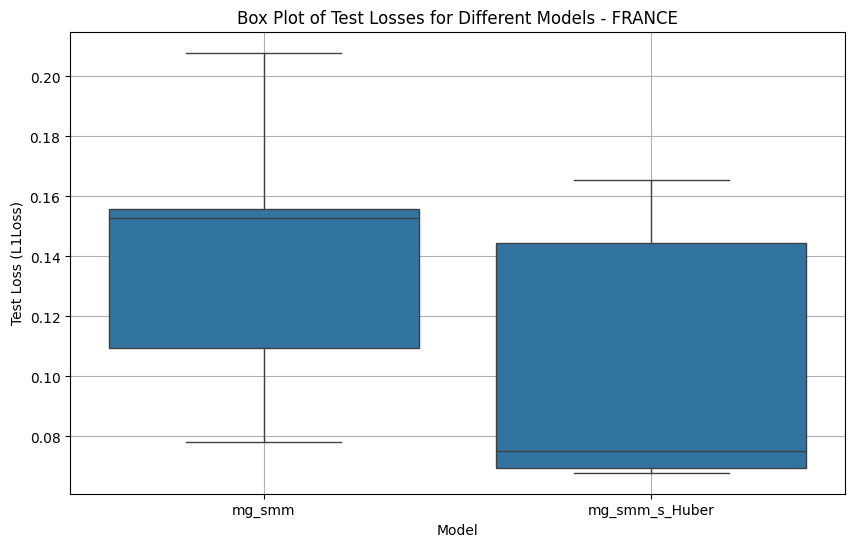

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a DataFrame for easier plotting with seaborn
show_results = All_result

for i, country_result in enumerate(show_results):
    loss_data = {
        'Model': [],
        'Test Loss': []
    }
    for model_name, value in country_result.items():
        if 'time' in model_name :
          continue
        elif "country" == model_name:
          country_name = value
          continue
        loss_data['Model'].extend([model_name.replace('_test_losses', '')] * len(value))
        loss_data['Test Loss'].extend(value)

    loss_df = pd.DataFrame(loss_data)

    # Create the box plot for the current country
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Model', y='Test Loss', data=loss_df)
    plt.title(f'Box Plot of Test Losses for Different Models - {country_name}') # Updated title for clarity
    plt.ylabel('Test Loss (L1Loss)') # Updated ylabel to reflect the criterion used
    plt.grid(True)
    # plt.ylim(bottom=0) # Set the y-axis to start at 0
    plt.show()

#Analysis Part (from file)

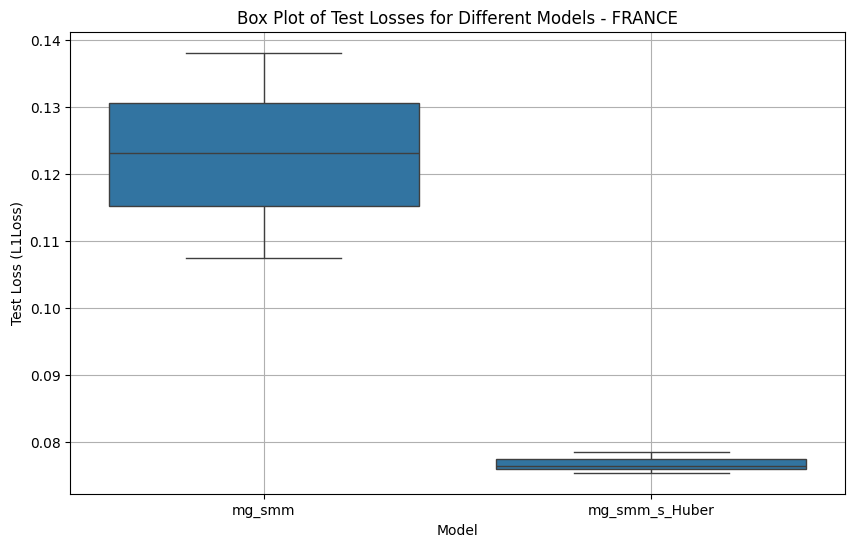

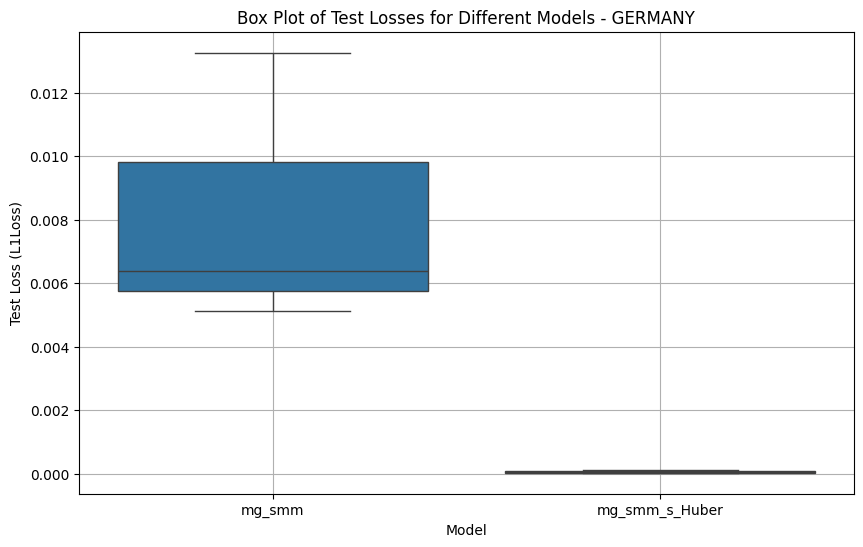

In [ ]:
import ast
import pandas as pd

combined_df = pd.read_csv('/content/raw_result_4_5.csv')
show_results = combined_df.drop(['Unnamed: 0'], axis = 1)
df_keys_list = show_results.keys()

saved_loss_data = []

for i in range(show_results.shape[0]):
    # country_name = selected_country_names[i] # Get the country name using the index and start value
    # print(country_result)
    loss_data = {
        'Model': [],
        'Test Loss': []
    }
    for df_key in df_keys_list:
        if 'time' in df_key :
          continue
        elif "country" == df_key:
          country_name = show_results[df_key][i]
          continue
        # display(show_results[df_key])
        loss_results = show_results[df_key][i]
        loss_results = ast.literal_eval(loss_results)

        loss_data['Model'].extend([df_key.replace('_test_losses', '')] * len(loss_results))
        loss_data['Test Loss'].extend(loss_results)

    loss_df = pd.DataFrame(loss_data)
    saved_loss_data.append(loss_data)

    # Create the box plot for the current country
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Model', y='Test Loss', data=loss_df)
    plt.title(f'Box Plot of Test Losses for Different Models - {country_name}') # Updated title for clarity
    plt.ylabel('Test Loss (L1Loss)') # Updated ylabel to reflect the criterion used
    plt.grid(True)
    # plt.ylim(bottom=0) # Set the y-axis to start at 0
    plt.show()

##P-value part

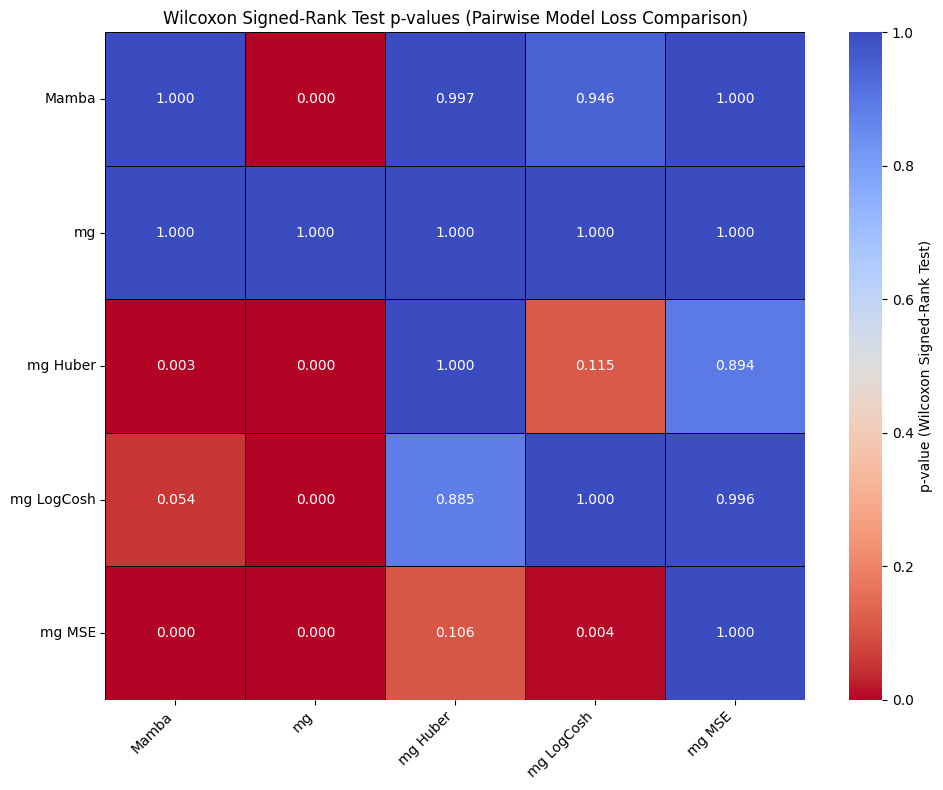

In [ ]:
# for combine file
import pandas as pd
import ast
from scipy.stats import wilcoxon
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# File and columns
file_name = "/content/sorted_raw_performance.csv"
loss_cols = ['custom_Mamba_test_losses', 'mg_smm_s_test_losses', 'mg_smm_s_test_losses_Huber', 'mg_smm_s_test_losses_LogCosh', 'mg_smm_s_test_losses_MSE']

# 1. Load the data
df = pd.read_csv(file_name)

# 2. Data Cleaning/Conversion
def safe_literal_eval(x):
    """Safely converts a string representation of a list into a Python list."""
    try:
        if isinstance(x, str):
            x = x.strip()
            # Handle empty/NaN-like strings
            if x.lower() in ('nan', 'none', 'null', ''):
                return []
        return ast.literal_eval(x)
    except (ValueError, SyntaxError, TypeError):
        # Return an empty list if evaluation fails
        return []

# Apply the conversion function to the loss columns
for col in loss_cols:
    df[col] = df[col].apply(safe_literal_eval)

# 3. Prepare for Wilcoxon Test (Explode)
# Explode the lists to get a single loss measurement per row, which maintains the pairing
df_exploded = df.explode(loss_cols).reset_index(drop=True)

# Convert exploded columns to float
for col in loss_cols:
    df_exploded[col] = pd.to_numeric(df_exploded[col], errors='coerce')

# Drop any rows where any of the paired loss values is missing/NaN
df_exploded = df_exploded.dropna(subset=loss_cols)

# 4. Perform Wilcoxon Test
num_models = len(loss_cols)
p_value_matrix = pd.DataFrame(index=loss_cols, columns=loss_cols, dtype=float)

for i in range(num_models):
    for j in range(num_models):
        model_a = loss_cols[i]
        model_b = loss_cols[j]

        if i == j:
            p_value_matrix.loc[model_a, model_b] = 1.0  # Comparison with itself
            continue

        # Wilcoxon Signed-Rank Test for paired samples: model_a vs model_b
        stat, p_value = wilcoxon(df_exploded[model_a], df_exploded[model_b],
                                 zero_method='wilcox', alternative='less', nan_policy='omit')

        p_value_matrix.loc[model_a, model_b] = p_value

# Save the p-value matrix to a CSV file
p_value_matrix.to_csv('wilcoxon_p_values.csv')

# 5. Create Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(p_value_matrix, annot=True, fmt=".3f", cmap="coolwarm_r", # coolwarm_r makes smaller p-values (significant) darker
            cbar_kws={'label': 'p-value (Wilcoxon Signed-Rank Test)'},
            linewidths=.5, linecolor='black', vmin=0, vmax=1.0)

plt.title('Wilcoxon Signed-Rank Test p-values (Pairwise Model Loss Comparison)')
# Adjust labels for better readability
new_labels = [col.replace('_test_losses', '').replace('custom_', '').replace('_smm_s', '').replace('_', ' ') for col in loss_cols]
plt.xticks(np.arange(len(new_labels)) + 0.5, new_labels, rotation=45, ha='right')
plt.yticks(np.arange(len(new_labels)) + 0.5, new_labels, rotation=0)

plt.tight_layout()
plt.savefig('wilcoxon_heatmap.png')

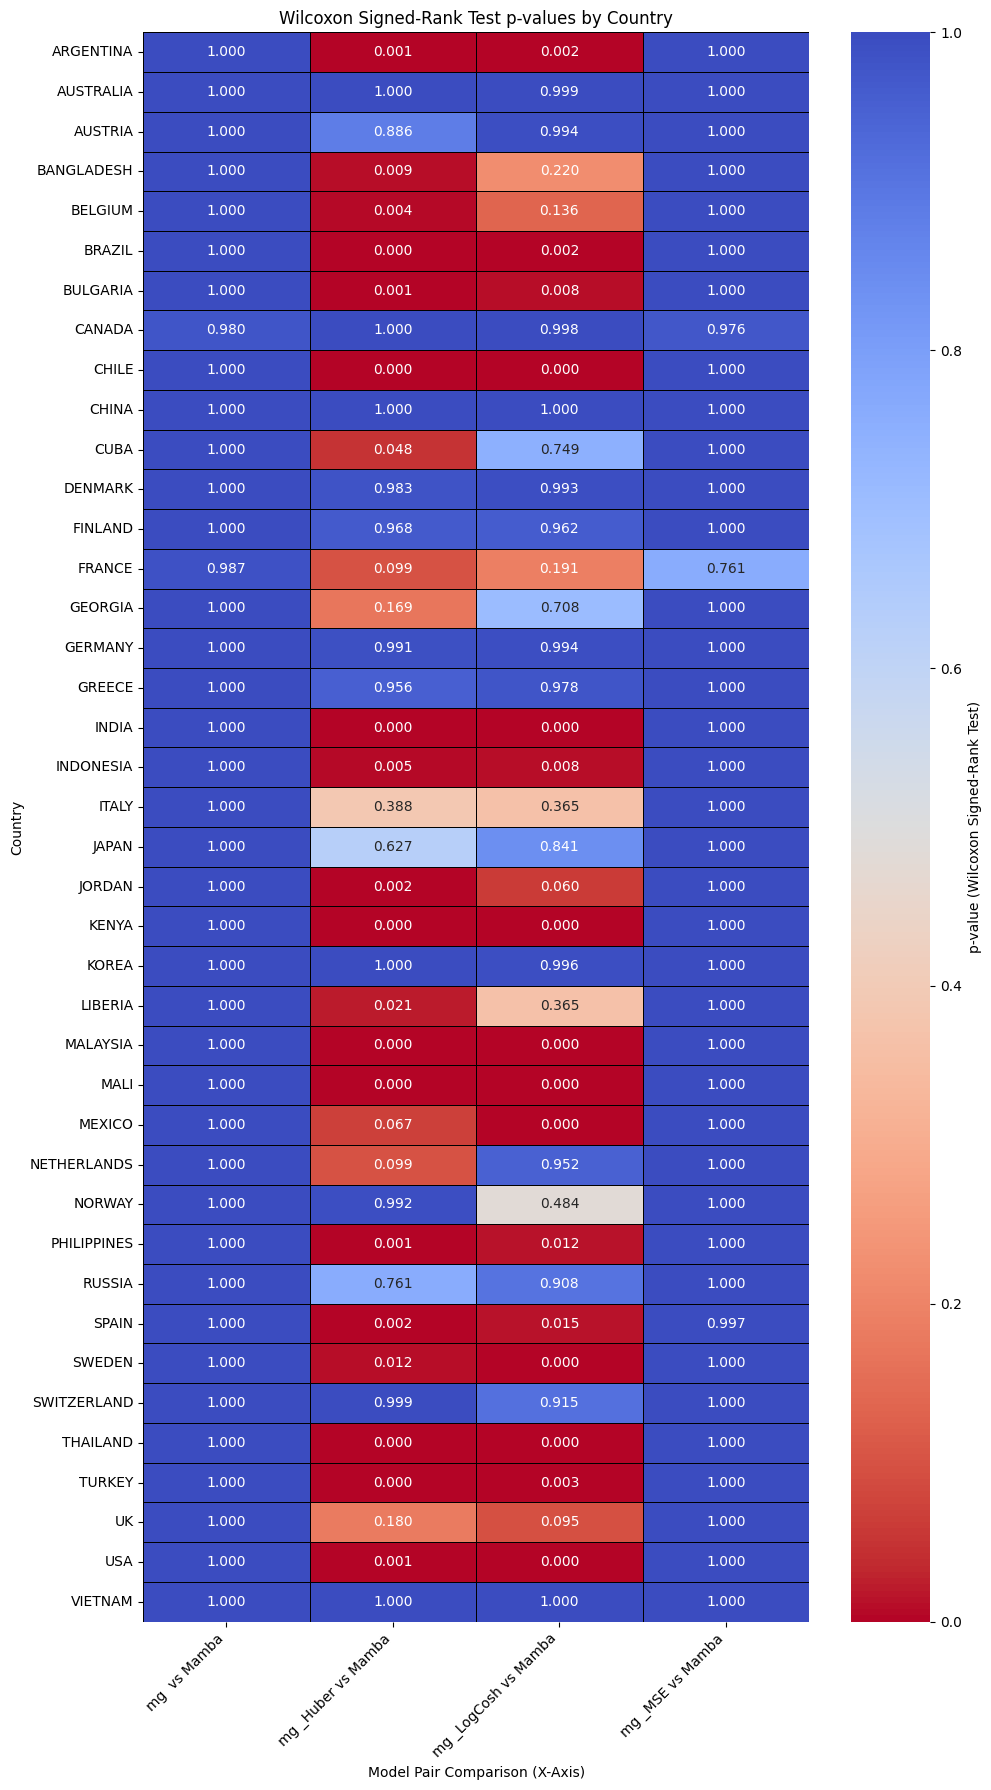

In [ ]:
import pandas as pd
import ast
from scipy.stats import wilcoxon
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- Configuration ---
file_name = "combined_mg_smm_s_loss_full.csv"
loss_cols = [
    'custom_Mamba_test_losses',
    'mg_smm_s_test_losses',
    'mg_smm_s_test_losses_Huber',
    'mg_smm_s_test_losses_LogCosh',
    'mg_smm_s_test_losses_MSE'
]
# The column containing country names (initially 'Unnamed: 0')
country_col = 'Unnamed: 0'

# Define the requested pairs for comparison (X-axis)
pairs_to_test = [
    ("mg_smm_s_test_losses", "custom_Mamba_test_losses"),
    ("mg_smm_s_test_losses_Huber", "custom_Mamba_test_losses"),
    ("mg_smm_s_test_losses_LogCosh", "custom_Mamba_test_losses"),
    ("mg_smm_s_test_losses_MSE", "custom_Mamba_test_losses")
]

# 1. Load the data
df = pd.read_csv(file_name)

# Rename the country column for clarity
if country_col in df.columns:
    df = df.rename(columns={country_col: 'Country'})
    country_col = 'Country'

# 2. Data Cleaning/Conversion
def safe_literal_eval(x):
    """Safely converts a string representation of a list into a Python list."""
    try:
        if isinstance(x, str):
            x = x.strip()
            if x.lower() in ('nan', 'none', 'null', ''):
                return []
        return ast.literal_eval(x)
    except (ValueError, SyntaxError, TypeError):
        return []

# Apply the conversion function to the loss columns
for col in loss_cols:
    df[col] = df[col].apply(safe_literal_eval)

# 3. Prepare for Wilcoxon Test (Explode)
# Explode the lists to get a single loss measurement per row, which maintains the pairing
df_exploded = df.explode(loss_cols).reset_index(drop=True)

# Convert exploded columns to float
for col in loss_cols:
    df_exploded[col] = pd.to_numeric(df_exploded[col], errors='coerce')

# 4. Perform Wilcoxon Test per Country
p_value_data = {}
grouped = df_exploded.groupby(country_col)

for model_A, model_B in pairs_to_test:
    # Create a clear name for the pair/column
    pair_name = (
        f"{model_A.replace('_test_losses', '').replace('_smm_s', ' ')} "
        f"vs {model_B.replace('_test_losses', '').replace('custom_', '')}"
    )
    p_values = {}

    for country, group in grouped:
        # Align series by dropping NaNs where data is missing for *either* model in the pair
        combined = group[[model_A, model_B]].dropna()
        series_A = combined[model_A]
        series_B = combined[model_B]

        if len(series_A) < 5: # Skip test if too few samples remain after cleaning
            p_values[country] = np.nan
            continue

        try:
            # Wilcoxon Signed-Rank Test for paired samples
            stat, p_value = wilcoxon(
                series_A, series_B,
                zero_method='wilcox',      # Method for handling zero differences
                alternative='less',   # Tests for any difference (A > B or A < B)
                nan_policy='omit'
            )
            p_values[country] = p_value

        except ValueError as e:
            # Handle the specific case where all differences are zero (which means p=1.0)
            if "samples must have at least one non-zero difference" in str(e):
                p_values[country] = 1.0
            else:
                p_values[country] = np.nan

    p_value_data[pair_name] = p_values

# Convert the dictionary to the final DataFrame (Countries as index, Pairs as columns)
p_value_matrix = pd.DataFrame(p_value_data)

# Sort by Country for better visualization
p_value_matrix = p_value_matrix.sort_index()

# Save the p-value matrix to a CSV file (includes NaNs where tests failed)
p_value_matrix.to_csv('wilcoxon_p_values_by_country.csv')

# Fill NaN values with a high p-value (1.0) for the heatmap visualization
p_value_matrix_plot = p_value_matrix.fillna(1.0)

# 5. Create Heatmap
plt.figure(figsize=(10, p_value_matrix.shape[0] * 0.45)) # Dynamic height based on number of countries
sns.heatmap(
    p_value_matrix_plot,
    annot=True,
    fmt=".3f",
    cmap="coolwarm_r", # Red=significant (small p), Blue=non-significant (large p)
    cbar_kws={'label': 'p-value (Wilcoxon Signed-Rank Test)'},
    linewidths=.5,
    linecolor='black',
    vmin=0,
    vmax=1.0
)

plt.title('Wilcoxon Signed-Rank Test p-values by Country')
plt.ylabel('Country')
plt.xlabel('Model Pair Comparison (X-Axis)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()

# Save the plot
output_file = 'wilcoxon_heatmap_country_vs_pairs.png'
plt.savefig(output_file)

In [ ]:
df_p_values

,mg smm s vs custom Mamba,Huber vs custom Mamba,LogCosh vs custom Mamba,MSE vs custom Mamba
Country,,,,
USA,0.995349,1.045633e-04,1.010091e-03,8.215606e-03
INDIA,0.881674,5.304813e-06,1.895241e-06,1.524761e-05
BRAZIL,0.957967,5.304813e-06,1.170507e-02,1.619570e-06
FRANCE,0.000333,1.010091e-03,1.239303e-02,4.965755e-03
GERMANY,0.988295,3.575665e-01,9.429117e-01,1.542604e-01
UK,0.998990,1.239303e-02,4.758872e-04,1.093888e-03
RUSSIA,0.977546,1.908992e-01,9.827316e-01,2.712640e-01
ITALY,0.935323,9.264740e-03,2.332402e-03,2.024486e-02
TURKEY,0.998262,1.010091e-03,6.869715e-05,1.416318e-04


In [ ]:
import pandas as pd
import numpy as np

# Load the dataset
# Assuming 'overall_time.csv' contains the data you are interested in.

# --- Step 1: Define the threshold ---
thresholds = [0.1, 0.05, 0.01]

# --- Step 2: Apply a boolean mask to the entire DataFrame ---
# This creates a DataFrame of True/False values where True means the value is < 0.01
df_emtpy = pd.DataFrame()
for threshold in thresholds:
  df_boolean = df_p_values < threshold
  count_series = df_boolean.sum(axis=0)
  df_emtpy['p<'+str(threshold)] = count_series
# --- Step 3: Sum the True values down the rows (axis=0) ---
# Summing the boolean DataFrame counts the number of 'True' occurrences in each column.
# The result is a pandas Series where the index is the column name and the value is the count.
df_emtpy



,p<0.1,p<0.05,p<0.01
mg smm s vs custom Mamba,1,1,1
Huber vs custom Mamba,25,23,19
LogCosh vs custom Mamba,20,19,16
MSE vs custom Mamba,23,22,19


# Utils

## Combine files

In [ ]:
import glob
import pandas as pd

# Get a list of all files matching the pattern
all_files = glob.glob("raw_result_*.csv")

# Create an empty list to store dataframes
li = []

# Read each file and append its dataframe to the list
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

# Concatenate all dataframes in the list
combined_df = pd.concat(li, axis=0, ignore_index=False)

# Save the combined dataframe to a new CSV file
combined_df.to_csv("combined_raw_result.csv", index=True)

print("All 'raw_result*.csv' files have been combined into 'combined_raw_result.csv'")

All 'raw_result*.csv' files have been combined into 'combined_raw_result.csv'


## File modify

In [ ]:
import pandas as pd

# Load the datasets
df_hidden = pd.read_csv('/content/best_param_baseline_3_3.csv')

df_hidden.rename(columns={'Unnamed: 0': 'country'}, inplace=True)
df_hidden_indexed = df_hidden.set_index('country')

df_final = df_hidden_indexed.reset_index().drop([col for col in df_hidden.columns if 'time' in col], axis = 1)
display(df_final)

# Save the final DataFrame to a new CSV file
df_final.to_csv('only_loss_gate_hidden.csv', index=False)

,country,custom_Mamba_test_losses,mg_smm_test_losses,mg_smm_s_test_losses,mg_smm_s_test_losses_Huber,mg_smm_s_test_losses_LogCosh,mg_smm_s_test_losses_MSE
0,ht_32,[0.0008612138626631349],[0.0033101768931373954],[0.02265922538936138],[5.787258714917698e-06],[4.181632448307937e-06],[4.2654558001231635e-06]


## Hidden dimension analysis

In [ ]:
df_other_hidden_loss = pd.read_csv('/content/only_loss_gate_hidden.csv')
df_other_hidden_loss

,country,custom_Mamba_test_losses,mg_smm_test_losses,mg_smm_s_test_losses,mg_smm_s_test_losses_Huber,mg_smm_s_test_losses_LogCosh,mg_smm_s_test_losses_MSE
0,ht_32,[0.0008612138626631349],[0.0033101768931373954],[0.02265922538936138],[5.787258714917698e-06],[4.181632448307937e-06],[4.2654558001231635e-06]


0.0008612138626631349
0.0033101768931373954
0.02265922538936138
5.787258714917698e-06
4.181632448307937e-06
4.2654558001231635e-06


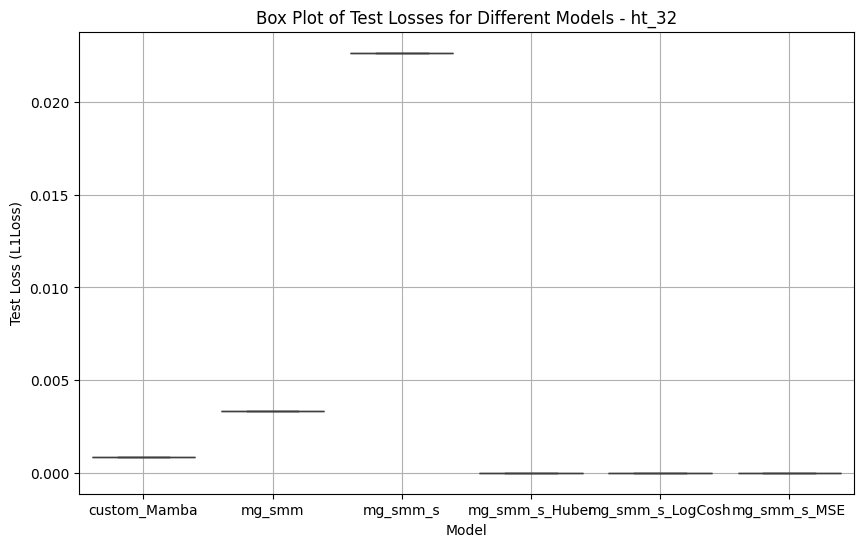

In [ ]:
import ast
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

country_from_csv = df_other_hidden_loss['country'].tolist()
losses_function_from_csv = df_other_hidden_loss.columns.tolist()[1:]
saved_loss_data = []

for country_name in country_from_csv:
    # print(country_result)
    loss_data = {
        'Model': [],
        'Test Loss': []
    }
    for losses in losses_function_from_csv:
        loss_results = df_other_hidden_loss[losses].iloc[country_from_csv.index(country_name)]
        loss_results = ast.literal_eval(loss_results)

        print(np.average(loss_results))

        loss_data['Model'].extend([losses.replace('_test_losses', '')] * len(loss_results))
        loss_data['Test Loss'].extend(loss_results)

    loss_df = pd.DataFrame(loss_data)
    saved_loss_data.append(loss_data)

    # Create the box plot for the current country
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Model', y='Test Loss', data=loss_df)
    plt.title(f'Box Plot of Test Losses for Different Models - {country_name}') # Updated title for clarity
    plt.ylabel('Test Loss (L1Loss)') # Updated ylabel to reflect the criterion used
    plt.grid(True)
    # plt.ylim(bottom=0) # Set the y-axis to start at 0
    plt.show()

#Appendix

## Saving model weighted

In [ ]:
def mg_smm_s_part_saved_model(train_data, eval_loader, test_data, num_runs, loss_function = nn.L1Loss(), eval_function = nn.MSELoss(), gate_size = 32, country_run = "named"):  #train_raw_loader, test_raw_loader
  # Initialize a list to store test losses
  mg_smm_s_test_losses = []
  best_test_loss = float('inf')

  for run in range(num_runs):
      print(f"\n--- mg_smm_s Mamba Run {run + 1}/{num_runs} ---")

      # Initialize the model
      model = MgSmmSModel(input_size, hidden_size, num_layers, output_size, gate_size)

      # Define loss function and optimizer
      criterion = loss_function
      optimizer = optim.Adam(model.parameters(), lr=learning_rate)

      # Early stopping parameters
      best_eval_loss = float('inf')
      patience = 50  # Number of epochs to wait for improvement
      epochs_no_improve = 0

      # Training loop
      # print("Starting training...")
      for epoch in range(num_epochs):
          model.train()
          for i, (sequences, targets) in enumerate(train_data):
              # Forward pass
              outputs = model(sequences)
              loss = criterion(outputs, targets)

              # Backward and optimize
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()

          # Evaluation on the evaluation set
          model.eval()
          with torch.no_grad():
              eval_loss = 0
              for sequences, targets in eval_loader:

                  outputs = model(sequences)
                  eval_loss += criterion(outputs, targets).item()

              avg_eval_loss = eval_loss / len(eval_loader)

          # Early stopping check
          if avg_eval_loss < best_eval_loss:
              best_eval_loss = avg_eval_loss
              epochs_no_improve = 0
              # Optionally save the best model state
              # torch.save(model.state_dict(), 'best_model.pth')
          else:
              epochs_no_improve += 1
              if epochs_no_improve == patience:
                  print(f'Early stopping at epoch {epoch+1}')
                  break # Stop training loop

      # Evaluation on the test set
      model.eval()
      with torch.no_grad():
          test_loss = 0
          for sequences, targets in test_data:
              outputs = model(sequences)
              test_loss += eval_function(outputs, targets).item()

          avg_test_loss = test_loss / len(test_data)
          print(f'mg_smm_s Test Loss: {avg_test_loss:.4f}')
          mg_smm_s_test_losses.append(avg_test_loss)

          if avg_test_loss < best_test_loss:
              best_test_loss = avg_test_loss
              print(f"New best_{country_run}_model")
              torch.save(model.state_dict(), f'best_{country_run}_model.pth')
  return mg_smm_s_test_losses

In [ ]:
from os import name
country_name_2idx = {}
for i in range(len(selected_country_names)):
  name = selected_country_names[i]
  country_name_2idx[name] = i

selected_names = ['USA' ,
                            'VIETNAM',
                            'JORDAN',
                            'KOREA',
                            'LIBERIA']
idx_for_run = [country_name_2idx[i] for i in selected_names]

In [ ]:
import torch
import time
from torchmetrics.regression import LogCoshError

num_runs = 10
start = 20
stop = 50

All_result = []

print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU available")

for i in idx_for_run:
  idx = i
  data = data_list[idx]
  print(selected_country_names[idx])

  X_raw_train, y_raw_train, X_raw_test, y_raw_test = data

  eval_size = int(len(X_raw_test) * 0.5)
  X_raw_eval, X_raw_test =  X_raw_test[:eval_size], X_raw_test[eval_size:]
  y_raw_eval, y_raw_test = y_raw_test[:eval_size], y_raw_test[eval_size:]

  country_run = {}

  train_data = TensorDataset(X_raw_train, y_raw_train)
  eval_data = TensorDataset(X_raw_eval, y_raw_eval)
  test_data = TensorDataset(X_raw_test, y_raw_test)

  train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
  eval_loader = DataLoader(eval_data, batch_size=batch_size, shuffle=False)
  test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

  # best param set
  hidden_size = 64

  start_time = time.time()
  mg_smm_s_test_losses = mg_smm_s_part_saved_model(train_loader, eval_loader, test_loader, num_runs, nn.HuberLoss(), nn.MSELoss(), gate_size = 64, country_run= selected_country_names[idx])
  end_time = time.time()
  elasped_time = end_time - start_time
  country_run['mg_smm_s_test_losses_Huber'] = mg_smm_s_test_losses
  country_run['mg_smm_s_test_losses_Huber_time'] = elasped_time

  All_result.append(country_run)


True
Tesla T4
USA

--- mg_smm_s Mamba Run 1/10 ---
Early stopping at epoch 113
mg_smm_s Test Loss: 0.0000
New best_USA_model

--- mg_smm_s Mamba Run 2/10 ---
Early stopping at epoch 95
mg_smm_s Test Loss: 0.0000
New best_USA_model

--- mg_smm_s Mamba Run 3/10 ---
Early stopping at epoch 116
mg_smm_s Test Loss: 0.0000
New best_USA_model

--- mg_smm_s Mamba Run 4/10 ---
Early stopping at epoch 355
mg_smm_s Test Loss: 0.0000

--- mg_smm_s Mamba Run 5/10 ---
Early stopping at epoch 109
mg_smm_s Test Loss: 0.0000

--- mg_smm_s Mamba Run 6/10 ---
Early stopping at epoch 87
mg_smm_s Test Loss: 0.0000

--- mg_smm_s Mamba Run 7/10 ---
Early stopping at epoch 263
mg_smm_s Test Loss: 0.0000

--- mg_smm_s Mamba Run 8/10 ---
Early stopping at epoch 85
mg_smm_s Test Loss: 0.0001

--- mg_smm_s Mamba Run 9/10 ---
Early stopping at epoch 95
mg_smm_s Test Loss: 0.0000

--- mg_smm_s Mamba Run 10/10 ---
Early stopping at epoch 98
mg_smm_s Test Loss: 0.0000
VIETNAM

--- mg_smm_s Mamba Run 1/10 ---
Early st